# Introduction to Semantic Segmentation

## What is Segmentation?

[README lost]

## Applications of Segmentation

[README lost]

## Using torchvision for Semantic Segmentation

Now before we get started, we need to know about the inputs and outputs of these semantic segmentation models.<br/>
So, let's start!

These models expect a 3-channled image which is normalized with the Imagenet mean and standard deviation, i.e., <br/>
`mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

So, the input is `[Ni x Ci x Hi x Wi]`<br/>
where,
- `Ni` -> the batch size
- `Ci` -> the number of channels (which is 3)
- `Hi` -> the height of the image
- `Wi` -> the width of the image

And the output of the model is `[No x Co x Ho x Wo]`<br/>
where,
- `No` -> is the batch size (same as `Ni`)
- `Co` -> **is the number of classes that the dataset have!**
- `Ho` -> the height of the image (which is the same as `Hi` in almost all cases)
- `Wo` -> the width of the image (which is the same as `Wi` in almost all cases)

Alright! And just one more thing!
The `torchvision` models outputs an `OrderedDict` and not a `torch.Tensor` <br/>
This `OrderedDict` has 2 keys:
- `aux`
- `out`

The `out` key of this `OrderedDict` is the key that holds the output.
So, this `out` key's value has the shape of `[No x Co x Ho x Wo]`.

Now! we are ready to play :)

### FCN with Resnet-101 backbone

In [9]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:09<00:00, 22741173.26it/s]
Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 217800805/217800805 [00:08<00:00, 24994132.96it/s]


And that's it we have a pretrained model of `FCN` (which stands for Fully Convolutional Neural Networks) with a `Resnet101` backbone :)

Now, let's get an image!

2019-06-02 06:45:44 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg?w968h681 [31327/31327] -> "r.png" [1]


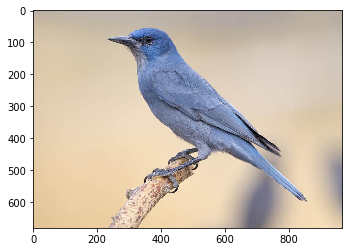

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg?w968h681 -O r.png
img = Image.open('./r.png')
plt.imshow(img); plt.show()

Now, that we have the image we need to preprocess it and normalize it! <br/>
So, for the preprocessing steps, we:
- Resize the image to `(256 x 256)`
- CenterCrop it to `(224 x 224)`
- Convert it to Tensor - all the values in the image becomes between `[0, 1]` from `[0, 255]`
- Normalize it with the Imagenet specific values `mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

And lastly, we unsqueeze the image so that it becomes `[1 x C x H x W]` from `[C x H x W]` <br/>
We need a batch dimension while passing it to the models.

In [0]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

Let's see what the above code cell does </br>
`T.Compose` is a function that takes in a `list` in which each element is of `transforms` type and </br>
it returns a object through which we can
pass batches of images and all the required transforms will be applied to the images.

Let's take a look at the transforms applied on the images:
- `T.Resize(256)` : Resizes the image to size `256 x 256`
- `T.CenterCrop(224)` : Center Crops the image to have a resulting size of `224 x 224`
- `T.ToTensor()` : Converts the image to type `torch.Tensor` and have values between `[0, 1]`
- `T.Normalize(mean, std)` : Normalizes the image with the given mean and standard deviation.

Alright! Now that we have the image all preprocessed and ready! Let's pass it through the model and get the `out` key.<br/>
As I said, the output of the model is a `OrderedDict` so, we need to take the `out` key from that to get the output of the model.

In [12]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


Alright! So, `out` is the final output of the model. And as we can see, its shape is `[1 x 21 x H x W]` as discussed earlier. So, the model was trained on `21` classes and thus our output have `21` channels!<br/>

Now, what we need to do is make this `21` channeled output into a `2D` image or a `1` channeled image, where each pixel of that image corresponds to a class!

So, the `2D` image, (of shape `[H x W]`) will have each pixel corresponding to a class label, and thus <br/>
for each `(x, y)` in this `2D` image will correspond to a number between `0 - 20` representing a class.

And how do we get there from this `[1 x 21 x H x W]`?<br/>
We take a max index for each pixel position, which represents the class<br/>

In [13]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[0 3]


Alright! So, we as we can see now have a `2D` image. Where each pixel corresponds to a class!
The last thing is to take this `2D` image where each pixel corresponds to a class label and convert this<br/>
into a segmentation map where each class label is converted into a `RGB` color and thus helping in easy visualization.

We will use the following function to convert this `2D` image to an `RGB` image wheree each label is mapped to its
corresponding color.

In [0]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

Let's see what we are doing inside this function!

first `label_colors` stores the colors for each of the clases, according to the index </br>
So, the color for the  first class which is `background` is stored in the `0`th index of the `label_colors` list, 
the second class which is `aeroplane` is stored at index `1` of `label_colors`.

Now, we are to create an `RGB` image from the `2D` image passed. So, what we do, is we create empty `2D` matrices for all 3 channels.

So, `r`, `g`, and `b` are arrays which will form the `RGB` channels for the final image. And each are of shape `[H x W]` 
(which is same as the shape of `image` passed in)

Now, we loop over each class color we stored in `label_colors`.
And we get the indexes in the image where that particular class label is present. (`idx = image == l`)
And then for each channel, we put its corresponding color to those pixels where that class label is present.

And finally we stack the 3 seperate channels to form a `RGB` image.

Okay! Now, let's use this function to see the final segmented output!

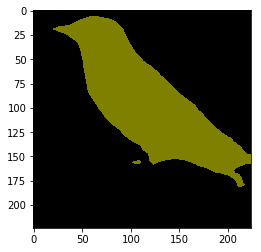

In [66]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

And there we go!!<br/>
Wooohooo! We have segmented the output of the image. 

That's the bird!

Next, let's move all this under one function and play with a few more images!

In [0]:
def segment(net, path):
  img = Image.open(path)
  plt.imshow(img); plt.show()
  trf = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0)
  out = net(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.show()

And let's get a new image!

2019-06-02 06:45:49 URL:https://www.airc.ie/wp-content/uploads/horse-web.jpg [951382/951382] -> "r.png" [1]


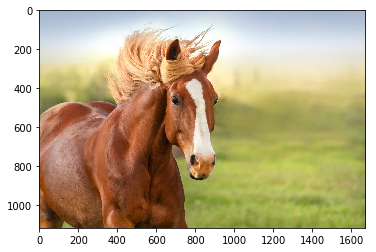

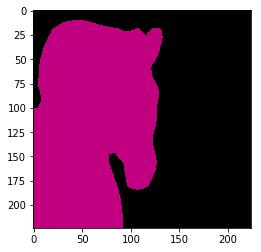

In [16]:
!wget -nv https://www.airc.ie/wp-content/uploads/horse-web.jpg -O r.png
segment(fcn, './r.png')

### DeepLab

In [17]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 244545539/244545539 [00:04<00:00, 56367237.60it/s]


Alright! Now we have god-level segmentation model!<br/>
Let's see how we perform with the same image on this model!

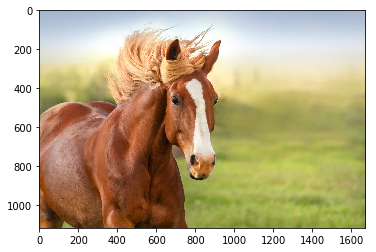

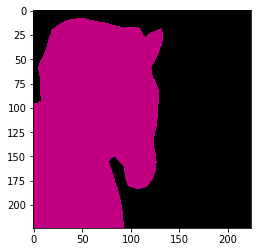

In [18]:
segment(dlab, './r.png')

Yeah! So, there you go! You can see that, the DeepLab model has also classified the image quite nicely! </br>
But if we take a more complex image! Then we start to see model differences! Do try out with a complex image and see !

For, now we will see how these two models compare with each other in 3 metrics
- Inference time
- Size of the model
- GPU memory used by the model

### GPU Memory usage

### Inference Time

In [0]:
import time

def infer_time(net, path='./r.png', dev='cuda'):
  img = Image.open(path)
  trf = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  
  st = time.time()
  out1 = fcn.to(dev)(inp)
  et = time.time()
  return et - st

**On CPU**

In [39]:
avg_over = 10

fcn_infer_time_avg_cpu = sum([infer_time(fcn, dev='cpu') for _ in range(avg_over)]) / avg_over
dlab_infer_time_avg_cpu = sum([infer_time(dlab, dev='cpu') for _ in range(avg_over)]) / avg_over

print ('The Average Inference time on FCN is:     {:.2f}s'.format(fcn_infer_time_avg_cpu))
print ('The Average Inference time on DeepLab is: {:.2f}s'.format(dlab_infer_time_avg_cpu))

The Average Inference time on FCN is:     1.70s
The Average Inference time on DeepLab is: 1.68s


As we can see, that 
- FCN with Resnet101 backbone takes `1.80`s time on CPU to infer 1 image
- DeepLabv3 with Resnet101 backbone takes `1.72`s time on CPU to infer 1 image

**On GPU**

In [38]:
avg_over = 10

fcn_infer_time_avg_gpu = sum([infer_time(fcn) for _ in range(avg_over)]) / avg_over
dlab_infer_time_avg_gpu = sum([infer_time(dlab) for _ in range(avg_over)]) / avg_over

print ('The Average Inference time on FCN is:     {:.2f}s'.format(fcn_infer_time_avg_gpu))
print ('The Average Inference time on DeepLab is: {:.2f}s'.format(dlab_infer_time_avg_gpu))

The Average Inference time on FCN is:     0.02s
The Average Inference time on DeepLab is: 0.02s


Alright!! We can see things fastened up in GPU, which is obvious!
- FCN with Resnet101 backbone takes `0.03`s time on CPU to infer 1 image
- DeepLabv3 with Resnet101 backbone takes `0.02`s time on CPU to infer 1 image

You can see that DeepLabv3 takes less time than the FCN,  which is not deeper than DeepLabv3

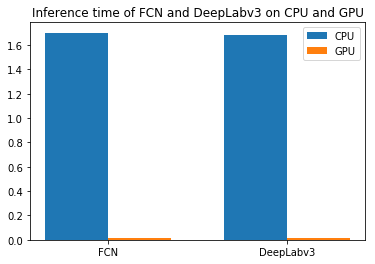

In [60]:
fig, ax = plt.subplots()
idx = np.arange(2); width = 0.35
p1 = ax.bar(idx, [fcn_infer_time_avg_cpu, dlab_infer_time_avg_cpu], width=width)
p2 = ax.bar(idx+width, [fcn_infer_time_avg_gpu, dlab_infer_time_avg_gpu], width=width)
ax.set_title('Inference time of FCN and DeepLabv3 on CPU and GPU')
ax.set_xticks(idx+width / 2)
ax.set_xticklabels(('FCN', 'DeepLabv3'))
ax.legend((p1[0], p2[0]), ('CPU', 'GPU'))
plt.show()

### Model Size

In [0]:
import os

resnet101_size = os.path.getsize('/root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth')
fcn_size = os.path.getsize('/root/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth')
dlab_size = os.path.getsize('/root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth')

fcn_total = fcn_size + resnet101_size
dlab_total = dlab_size + resnet101_size
    
print ('Size of the FCN model with Resnet101 backbone is:       {:.2f} MB'.format(fcn_total * 1e-6))
print ('Size of the DeepLabv3 model with Resnet101 backbone is: {:.2f} MB'.format(dlab_total * 1e-6))

Size of the FCN model with Resnet101 backbone is:       396.53 MB
Size of the DeepLabv3 model with Resnet101 backbone is: 423.27 MB


## Conclusion

Hope you enjoyed this tutorial!

Feel free to leave comments and any feedback you wish! If you would like to learn<br/>
more about this, how these techniques work and how to implement these models!

Please do check out the `Deep Learning with PyTorch` Course from OpenCV.org! <br/>
Link: https://opencv.org/ai-courses-by-opencv-kickstarter-campaign/